In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing Data from walmart sales csv

In [2]:
data=pd.read_csv("./Walmart_Sales.csv")

In [3]:
data

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1  05-02-2010    1643690.90             0        42.31       2.572   
1         1  12-02-2010    1641957.44             1        38.51       2.548   
2         1  19-02-2010    1611968.17             0        39.93       2.514   
3         1  26-02-2010    1409727.59             0        46.63       2.561   
4         1  05-03-2010    1554806.68             0        46.50       2.625   
...     ...         ...           ...           ...          ...         ...   
6430     45  28-09-2012     713173.95             0        64.88       3.997   
6431     45  05-10-2012     733455.07             0        64.89       3.985   
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

             CPI  Unemployment  
0     211.096358         8.106  
1     211.242170         8.106  
2     211.289143         8.106  
3     211.319643         8.106  
4     211.350143         8.106  
...          ...           ...  
6430  192.013558         8.684  
6431  192.170412         8.667  
6432  192.327265         8.667  
6433  192.330854         8.667  
6434  192.308899         8.667  

[6435 rows x 8 columns]

### [Optional] Lets imitate sql database by creating the database sales table

In [4]:
!pip install psycopg2-binary sqlalchemy plotly

In [5]:
import psycopg2
from sqlalchemy import create_engine

In [6]:
conn = psycopg2.connect(
    host="localhost",
    database="wallmart_sales",
    user="postgres",
    password="postgres"
)
cursor=conn.cursor()

#### Lets create a table within the database

In [7]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS wall_sales (
    Store INTEGER,
    Date DATE,
    Weekly_Sales NUMERIC,
    Holiday_Flag INTEGER,
    Temperature NUMERIC,
    Fuel_Price NUMERIC,
    CPI NUMERIC,
    Unemployment NUMERIC
);
""")
conn.commit()

#### Lets populate the table with the entries

In [8]:
for i, row in data.iterrows():
    cursor.execute("""
        INSERT INTO wall_sales (Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, (row['Store'], row['Date'], row['Weekly_Sales'], row['Holiday_Flag'], row['Temperature'], row['Fuel_Price'], row['CPI'], row['Unemployment']))
conn.commit()

DatetimeFieldOverflow: date/time field value out of range: "19-02-2010"
LINE 3:         VALUES (1, '19-02-2010', 1611968.17, 0, 39.93, 2.514...
                           ^
HINT:  Perhaps you need a different "datestyle" setting.


##### Postgres is not recognizing the date format, lets handle that first

In [9]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data[:5]

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

##### Its converted, lets insert the data back

In [10]:
for i, row in data.iterrows():
    cursor.execute("""
        INSERT INTO wall_sales (Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, (row['Store'], row['Date'], row['Weekly_Sales'], row['Holiday_Flag'], row['Temperature'], row['Fuel_Price'], row['CPI'], row['Unemployment']))
conn.commit()

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


##### InFailedSqlTransaction: current transaction is aborted means that a previous SQL command in this session failed, lets rollback the db connection

In [11]:
conn.rollback()

In [12]:
for i, row in data.iterrows():
    cursor.execute("""
        INSERT INTO wall_sales (Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, (row['Store'], row['Date'], row['Weekly_Sales'], row['Holiday_Flag'], row['Temperature'], row['Fuel_Price'], row['CPI'], row['Unemployment']))
conn.commit()

##### Data is successfully populated into the database, let's check our data by making a general select query

In [13]:
cursor.execute("""
select * from wall_sales
limit 5;
""")
query_result=pd.DataFrame(cursor.fetchall(),columns=["Store","Date","Weekly_Sales","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment"])
query_result

Store        Date Weekly_Sales  Holiday_Flag Temperature Fuel_Price  \
0      1  2011-04-01   1495064.75             0       59.17      3.524   
1      1  2011-04-08   1614259.35             0       67.84      3.622   
2      1  2010-02-05    1643690.9             0       42.31      2.572   
3      1  2010-02-12   1641957.44             1       38.51      2.548   
4      1  2010-02-19   1611968.17             0       39.93      2.514   

           CPI Unemployment  
0  214.8371664        7.682  
1  215.0743939        7.682  
2  211.0963582        8.106  
3  211.2421698        8.106  
4  211.2891429        8.106

#### Time for some Exploratortion of our Dataset

In [14]:
data.head()

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


##### Seems like there are no null values, although to confirm finally lets check null (NaN) values

In [16]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

##### Check for duplicates

In [17]:
duplicate_rows = data[data.duplicated()]
print("Number of exact duplicate rows:", duplicate_rows.shape[0])
print(duplicate_rows)

Number of exact duplicate rows: 0
Empty DataFrame
Columns: [Store, Date, Weekly_Sales, Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment]
Index: []


##### Lets create new meaningful features from the current dataframe

In [18]:
data['Sales_Category'] = pd.cut(data['Weekly_Sales'], bins=[100000, 750000, 2000000, float('inf')], labels=['Low','Medium','High'])
data.head()

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment Sales_Category  
0  211.096358         8.106         Medium  
1  211.242170         8.106         Medium  
2  211.289143         8.106         Medium  
3  211.319643         8.106         Medium  
4  211.350143         8.106         Medium

##### Creating date based features to capture seasonality effect

In [19]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Week']=round(((data["Day"].astype(int))/7)).astype(int)
data.head()

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment Sales_Category  Year  Month  Day  Week  
0  211.096358         8.106         Medium  2010      2    5     1  
1  211.242170         8.106         Medium  2010      2   12     2  
2  211.289143         8.106         Medium  2010      2   19     3  
3  211.319643         8.106         Medium  2010      2   26     4  
4  211.350143         8.106         Medium  2010      3    5     1

#### Querying the Database for Data Visualization and Analysis to understand our data better

In [20]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

##### Scenario 1: Sales trend by stores over years

In [21]:
query="""
select store,sum(weekly_sales) as w_sales, extract(month from date) as month from wall_sales
group by store, month
order by w_sales desc
Limit 20;
"""
cursor.execute(query)
sales_trend=pd.DataFrame(cursor.fetchall(),columns=["Store","Week Sales","month"])
sales_trend[:5]

Store   Week Sales month
0     14  58228596.18     4
1     20  57573170.52     4
2     20  57079773.58     7
3      4  56175273.34     4
4      4  55957989.02     7

In [22]:
pio.renderers.default = "notebook"

In [23]:
fig = px.bar(sales_trend, y='Week Sales', x='month', color='Store',
              title='Monthly Sales Trend per Store')
fig.show()

##### Scenario 2: Impact of Holiday on Sales

In [24]:
query="""
SELECT Holiday_Flag, AVG(Weekly_Sales) AS Avg_Sales, sum(Weekly_Sales) as totalsales
FROM wall_sales
GROUP BY Holiday_Flag;
"""
cursor.execute(query)
holiday_trend=pd.DataFrame(cursor.fetchall(),columns=["Holiday","Average Sales","Total Sales"])

holiday_trend

Holiday         Average Sales     Total Sales
0        0  1041256.380208855472  12463838871.10
1        1  1122887.892355555556   1010599103.12

In [25]:
fig = px.pie(holiday_trend, names='Holiday', values='Total Sales', 
             title='Sales Proportion: Holiday vs Non-Holiday')
fig.show()

##### Scenario 3: Store Performance Comparison

In [26]:
query="""
SELECT Store, SUM(Weekly_Sales) AS Total_Sales
FROM wall_sales
GROUP BY Store
ORDER BY Total_Sales DESC
LIMIT 10;
"""
cursor.execute(query)
store_perf=pd.DataFrame(cursor.fetchall(),columns=["Store","Total Sales"])
store_perf

Store   Total Sales
0     20  602795584.92
1      4  599087906.76
2     14  577999822.68
3     13  573035407.60
4      2  550764881.96
5     10  543235427.78
6     27  507711833.76
7      6  447512261.28
8      1  444805617.70
9     39  414891084.94

In [27]:
fig = px.bar(store_perf, y='Total Sales', x='Store',
              title='Top 10 performing Stores')
fig.show()

##### Scenario 4: Economic Factor Correlation

In [28]:
query="""
SELECT AVG(Weekly_Sales) AS Avg_Sales, AVG(CPI) AS Avg_CPI, AVG(Fuel_Price) AS Avg_Fuel
FROM wall_sales
GROUP BY extract(YEAR from Date), extract(MONTH from Date);
"""
cursor.execute(query)
ef_correlation=pd.DataFrame(cursor.fetchall(),columns=["Avg Sales","Avg CPI","Avg Fuel Price"])
ef_correlation


Avg Sales               Avg CPI      Avg Fuel Price
0    984821.646500000000  168.2550243577777778  2.7345166666666667
1   1068034.290888888889  168.0046878455555556  2.7880055555555556
2   1283380.145422222222  168.4592703613333333  2.9880977777777778
3   1048702.663611111111  175.6154385583333333  3.8498111111111111
4   1052670.069688888889  175.7750791097777778  3.6894800000000000
5   1167568.638166666667  173.2585092883333333  3.4831166666666667
6   1042445.060500000000  168.2118859883333333  2.7830000000000000
7    981545.504088888889  172.2542407644444444  3.6459555555555556
8    909466.482388888889  168.7918179705555556  3.1139555555555556
9   1009156.434222222222  171.3769961366666667  3.9643777777777778
10  1049560.588611111111  175.4966427600000000  3.9745444444444444
11  1035174.043722222222  169.5900348955555556  3.1730000000000000
12  1018118.239722222222  172.9096532305555556  3.5237055555555556
13  1280347.122133333333  173.7498526657777778  3.3305244444444444
14  1024231.557888888889  176.6109154611111111  3.8533611111111111
15  1028931.779955555556  175.1415447631111111  3.8155244444444444
16  1054296.584388888889  171.2267838733333333  3.7841055555555556
17  1057405.461333333333  167.8344589472222222  2.6919666666666667
18  1067019.886333333333  174.6183490616666667  3.5338722222222222
19   965163.662311111111  168.4536663551111111  2.8072800000000000
20  1033689.448800000000  168.0016328866666667  2.7739955555555556
21   996424.712722222222  170.3238876272222222  3.5219833333333333
22  1069379.241288888889  175.6037748786666667  3.6396488888888889
23   938302.620333333333  174.2676562133333333  3.3683500000000000
24  1041719.180000000000  175.6671836866666667  3.5050666666666667
25  1010665.569444444444  167.9308460466666667  2.7867055555555556
26  1006784.493200000000  171.0008047115555556  3.7699600000000000
27  1037282.968555555556  167.6417576016666667  2.9173500000000000
28  1047774.068055555556  171.8948330461111111  3.6960722222222222
29  1003586.358166666667  176.1852100616666667  3.8642722222222222
30  1028499.413555555556  167.6784365346666667  2.8685377777777778
31  1021828.439422222222  171.5725351600000000  3.6892222222222222
32  1126963.167444444444  168.6014596966666667  2.8862722222222222

In [29]:
fig_cpi = px.bar(ef_correlation, x='Avg CPI', y='Avg Sales',
                     title='CPI vs Weekly Sales')
fig_cpi.show()

fig_fuel = px.bar(ef_correlation, x='Avg Fuel Price', y='Avg Sales',
                      title='Fuel Price vs Weekly Sales')
fig_fuel.show()


### Data Modelling 

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix ,  mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

##### Lets check our data back so that we can decide test train splits and convert it to numerical figures

In [31]:
data[:5]

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment Sales_Category  Year  Month  Day  Week  
0  211.096358         8.106         Medium  2010      2    5     1  
1  211.242170         8.106         Medium  2010      2   12     2  
2  211.289143         8.106         Medium  2010      2   19     3  
3  211.319643         8.106         Medium  2010      2   26     4  
4  211.350143         8.106         Medium  2010      3    5     1

In [32]:
category_map = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}
data['Sales_Category'] = data['Sales_Category'].map(category_map)
data[:5]

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment Sales_Category  Year  Month  Day  Week  
0  211.096358         8.106              1  2010      2    5     1  
1  211.242170         8.106              1  2010      2   12     2  
2  211.289143         8.106              1  2010      2   19     3  
3  211.319643         8.106              1  2010      2   26     4  
4  211.350143         8.106              1  2010      3    5     1

### Machine Learning Models

### Predict CPI

### Linear Regression Model

In [33]:
features_cpi=data.drop(columns=["CPI","Date"])
output=data["CPI"]

In [34]:
x_train,x_test,y_train,y_test=train_test_split(features_cpi,output,test_size=0.2,random_state=12)

In [35]:
model_lr=LinearRegression()

In [36]:
model_lr.fit(x_train,y_train)

LinearRegression()

In [37]:
predict=model_lr.predict(x_test)
predict

array([173.09862999, 146.56575994, 154.18313036, ..., 172.24443126,
       164.71879712, 162.21987542], shape=(1287,))

##### Let's check the accuracy and scores for our linear regression model

In [38]:
def check_metrics(predict,y_test):
    MSE=mean_squared_error(y_pred=predict,y_true=y_test)
    MAE=mean_absolute_error(y_pred=predict,y_true=y_test)
    rmse = np.sqrt(MSE)
    r2 = r2_score(y_test, predict)
    print("MAE:", MAE)
    print("MSE:", MSE)
    print("RMSE:", rmse)
    print("R²:", r2)

In [39]:
check_metrics(predict,y_test)

MAE: 28.44780071464364
MSE: 1068.4926399749581
RMSE: 32.687805676963976
R²: 0.3145879938671431


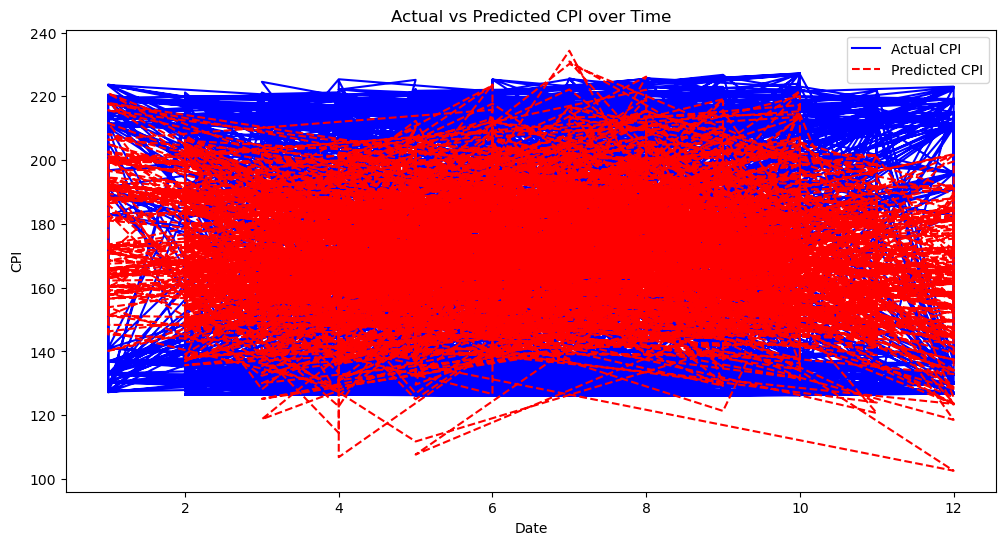

In [40]:
plt.figure(figsize=(12,6))
plt.plot(x_test["Month"], y_test, label="Actual CPI", color="blue")
plt.plot(x_test["Month"], predict, label="Predicted CPI", color="red", linestyle="dashed")

plt.title("Actual vs Predicted CPI over Time")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.show()

##### To visulize it better let's take lesser samples

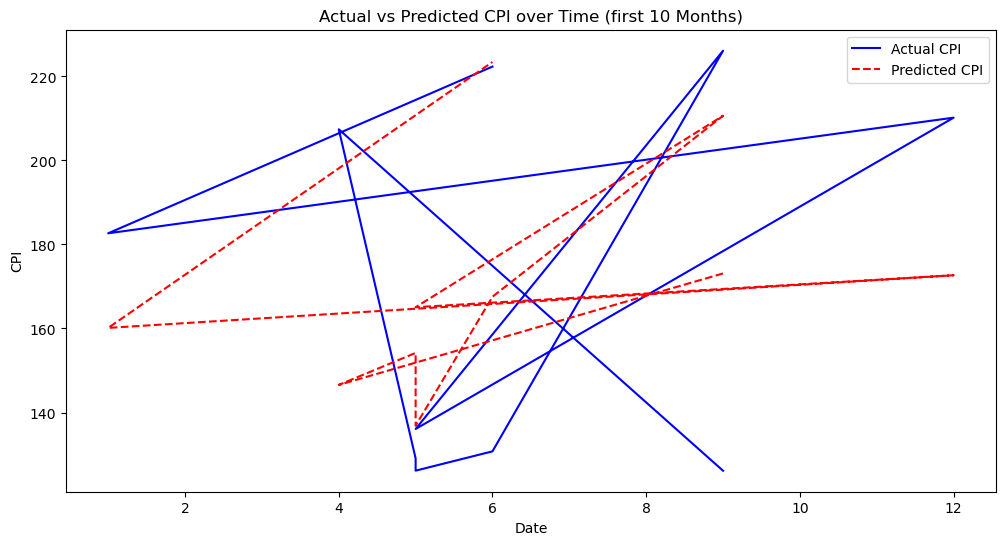

In [41]:
N = 10
plt.figure(figsize=(12,6))
plt.plot(x_test["Month"].iloc[:N], y_test.iloc[:N], label="Actual CPI", color="blue")
plt.plot(x_test["Month"].iloc[:N], predict[:N], label="Predicted CPI", color="red", linestyle="dashed")
plt.title(f"Actual vs Predicted CPI over Time (first {N} Months)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.show()

#### So as we can see, the predictions are way off from the actual, so lets take another model

#### Random Forest Regressor

In [42]:
model_rf=RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [43]:
predict=model_rf.predict(x_test)
predict

array([126.1274711 , 207.14049566, 128.95956468, ..., 132.77664165,
       138.75450274, 138.08847906], shape=(1287,))

In [44]:
check_metrics(predict,y_test)

MAE: 0.9827632392428085
MSE: 19.576534064989104
RMSE: 4.424537723309533
R²: 0.9874421301704738


#### Pretty Good Results with the metrics, lets go for plotting them first

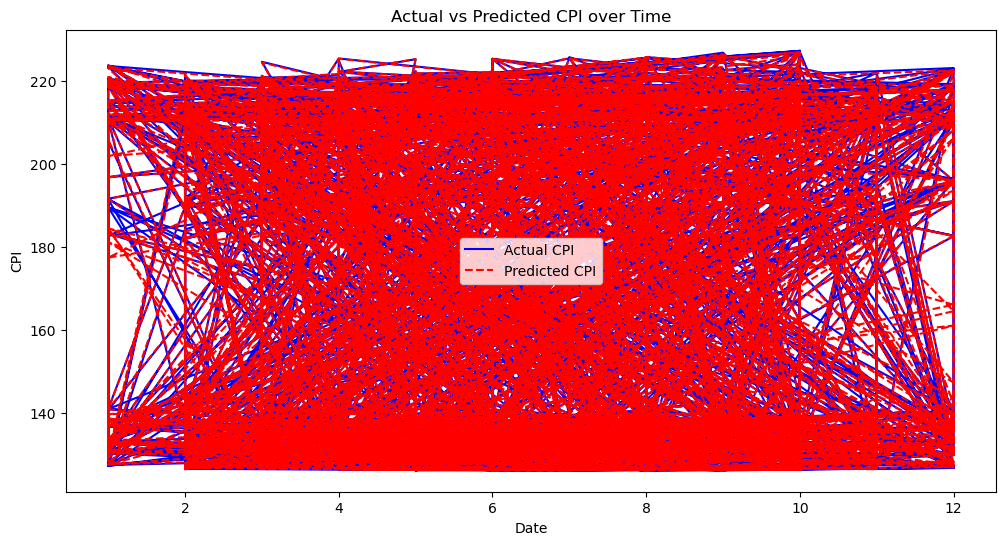

In [45]:
plt.figure(figsize=(12,6))
plt.plot(x_test["Month"], y_test, label="Actual CPI", color="blue")
plt.plot(x_test["Month"], predict, label="Predicted CPI", color="red", linestyle="dashed")

plt.title("Actual vs Predicted CPI over Time")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.show()

##### To visulize it better let's take lesser samples

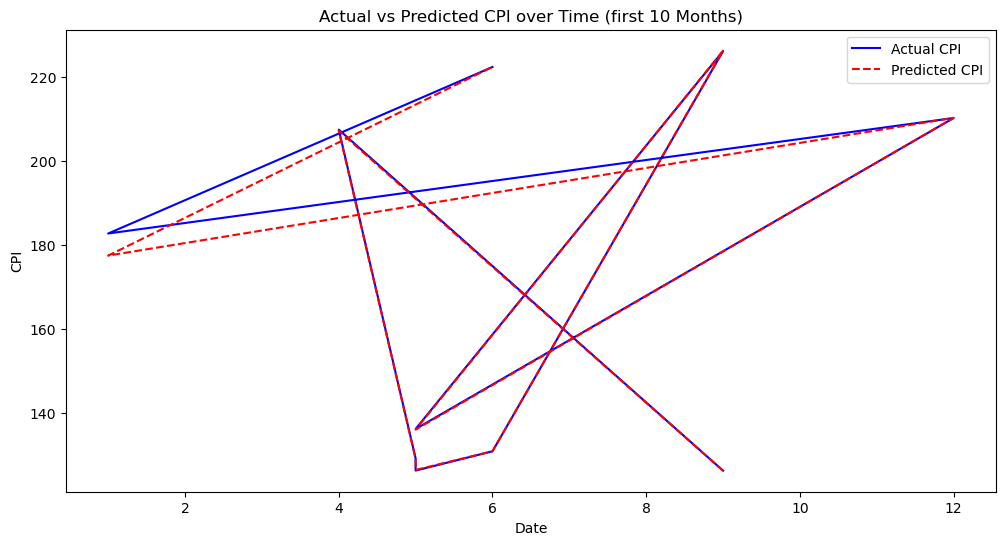

In [46]:
N = 10
plt.figure(figsize=(12,6))
plt.plot(x_test["Month"].iloc[:N], y_test.iloc[:N], label="Actual CPI", color="blue")
plt.plot(x_test["Month"].iloc[:N], predict[:N], label="Predicted CPI", color="red", linestyle="dashed")
plt.title(f"Actual vs Predicted CPI over Time (first {N} Months)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.show()

#### Just one last model to see if we can find one more accurate without overfitting

In [47]:
model_mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
model_mlp.fit(x_train, y_train)
predict = model_mlp.predict(x_test)

In [49]:
check_metrics(predict,y_test)

MAE: 87.97981219855191
MSE: 11029.342830736792
RMSE: 105.02067811025023
R²: -6.075054813779081


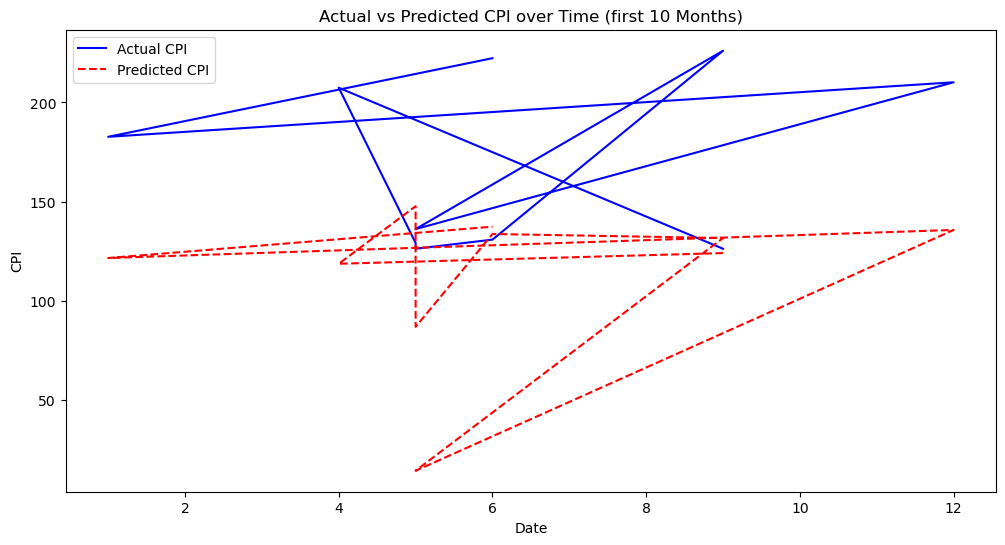

In [50]:
N = 10
plt.figure(figsize=(12,6))
plt.plot(x_test["Month"].iloc[:N], y_test.iloc[:N], label="Actual CPI", color="blue")
plt.plot(x_test["Month"].iloc[:N], predict[:N], label="Predicted CPI", color="red", linestyle="dashed")
plt.title(f"Actual vs Predicted CPI over Time (first {N} Months)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.show()

#### It is not accurate at all as compared to the Random Forest regressor

### Lets predict weekly sales for the next quarter or 12 weeks

In [51]:
data[:5]

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment Sales_Category  Year  Month  Day  Week  
0  211.096358         8.106              1  2010      2    5     1  
1  211.242170         8.106              1  2010      2   12     2  
2  211.289143         8.106              1  2010      2   19     3  
3  211.319643         8.106              1  2010      2   26     4  
4  211.350143         8.106              1  2010      3    5     1

In [52]:
data = data.sort_values(["Store", "Date"])
data["lag_1"] = data.groupby("Store")["Weekly_Sales"].shift(1)
data["lag_2"] = data.groupby("Store")["Weekly_Sales"].shift(2)
data["lag_3"] = data.groupby("Store")["Weekly_Sales"].shift(3)
data["lag_1"]=data["lag_1"].fillna("0")
data["lag_2"]=data["lag_2"].fillna("0")
data["lag_3"]=data["lag_3"].fillna("0")
data[:5]

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment Sales_Category  Year  Month  Day  Week  \
0  211.096358         8.106              1  2010      2    5     1   
1  211.242170         8.106              1  2010      2   12     2   
2  211.289143         8.106              1  2010      2   19     3   
3  211.319643         8.106              1  2010      2   26     4   
4  211.350143         8.106              1  2010      3    5     1   

        lag_1       lag_2       lag_3  
0           0           0           0  
1   1643690.9           0           0  
2  1641957.44   1643690.9           0  
3  1611968.17  1641957.44   1643690.9  
4  1409727.59  1611968.17  1641957.44

In [53]:
data["rolling_mean_4"] = data.groupby("Store")["Weekly_Sales"].shift(1).rolling(4).mean()
data["rolling_mean_12"] = data.groupby("Store")["Weekly_Sales"].shift(1).rolling(12).mean()

In [54]:
sales_data=data.dropna()
sales_data

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
12        1 2010-04-30    1425100.71             0        67.41       2.780   
13        1 2010-05-07    1603955.12             0        72.55       2.835   
14        1 2010-05-14    1494251.50             0        74.78       2.854   
15        1 2010-05-21    1399662.07             0        76.44       2.826   
16        1 2010-05-28    1432069.95             0        80.44       2.759   
...     ...        ...           ...           ...          ...         ...   
6430     45 2012-09-28     713173.95             0        64.88       3.997   
6431     45 2012-10-05     733455.07             0        64.89       3.985   
6432     45 2012-10-12     734464.36             0        54.47       4.000   
6433     45 2012-10-19     718125.53             0        56.47       3.969   
6434     45 2012-10-26     760281.43             0        58.85       3.882   

             CPI  Unemployment Sales_Category  Year  Month  Day  Week  \
12    210.389546         7.808              1  2010      4   30     4   
13    210.339968         7.808              1  2010      5    7     1   
14    210.337426         7.808              1  2010      5   14     2   
15    210.617093         7.808              1  2010      5   21     3   
16    210.896761         7.808              1  2010      5   28     4   
...          ...           ...            ...   ...    ...  ...   ...   
6430  192.013558         8.684              0  2012      9   28     4   
6431  192.170412         8.667              0  2012     10    5     1   
6432  192.327265         8.667              0  2012     10   12     2   
6433  192.330854         8.667              0  2012     10   19     3   
6434  192.308899         8.667              1  2012     10   26     4   

           lag_1       lag_2       lag_3  rolling_mean_4  rolling_mean_12  
12    1391256.12  1466058.28  1545418.53    1.499425e+06     1.514695e+06  
13    1425100.71  1391256.12  1466058.28    1.456958e+06     1.496479e+06  
14    1603955.12  1425100.71  1391256.12    1.471593e+06     1.493312e+06  
15     1494251.5  1603955.12  1425100.71    1.478641e+06     1.483503e+06  
16    1399662.07   1494251.5  1603955.12    1.480742e+06     1.482664e+06  
...          ...         ...         ...             ...              ...  
6430    723086.2   702238.27   766512.66    7.315338e+05     7.390079e+05  
6431   713173.95    723086.2   702238.27    7.262528e+05     7.281589e+05  
6432   733455.07   713173.95    723086.2    7.179884e+05     7.267954e+05  
6433   734464.36   733455.07   713173.95    7.260449e+05     7.265330e+05  
6434   718125.53   734464.36   733455.07    7.248047e+05     7.270708e+05  

[5895 rows x 18 columns]

In [55]:
X = sales_data.drop(columns=["Weekly_Sales", "Date"])
y = sales_data["Weekly_Sales"]

In [56]:
train_size = int(len(sales_data) * 0.85)

In [57]:
x_train=X[:train_size]
x_test=X[train_size:]
y_train=y[:train_size]
y_test=y[train_size:]

In [58]:
x_train

Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
12        1             0        67.41       2.780  210.389546         7.808   
13        1             0        72.55       2.835  210.339968         7.808   
14        1             0        74.78       2.854  210.337426         7.808   
15        1             0        76.44       2.826  210.617093         7.808   
16        1             0        80.44       2.759  210.896761         7.808   
...     ...           ...          ...         ...         ...           ...   
5473     39             0        61.62       2.689  210.720244         8.476   
5474     39             0        62.21       2.728  210.766794         8.476   
5475     39             0        55.50       2.771  210.654290         8.476   
5476     39             1        67.75       2.735  210.515276         8.476   
5477     39             0        53.55       2.708  210.376263         8.476   

     Sales_Category  Year  Month  Day  Week       lag_1       lag_2  \
12                1  2010      4   30     4  1391256.12  1466058.28   
13                1  2010      5    7     1  1425100.71  1391256.12   
14                1  2010      5   14     2  1603955.12  1425100.71   
15                1  2010      5   21     3   1494251.5  1603955.12   
16                1  2010      5   28     4  1399662.07   1494251.5   
...             ...   ...    ...  ...   ...         ...         ...   
5473              1  2010     11    5     1  1294769.08  1261109.01   
5474              1  2010     11   12     2  1293707.19  1294769.08   
5475              1  2010     11   19     3  1291398.71  1293707.19   
5476              2  2010     11   26     4  1370659.54  1291398.71   
5477              1  2010     12    3     0   2149355.2  1370659.54   

           lag_3  rolling_mean_4  rolling_mean_12  
12    1545418.53    1.499425e+06     1.514695e+06  
13    1466058.28    1.456958e+06     1.496479e+06  
14    1391256.12    1.471593e+06     1.493312e+06  
15    1425100.71    1.478641e+06     1.483503e+06  
16    1603955.12    1.480742e+06     1.482664e+06  
...          ...             ...              ...  
5473   1238742.0    1.270305e+06     1.303233e+06  
5474  1261109.01    1.272082e+06     1.296753e+06  
5475  1294769.08    1.285246e+06     1.281719e+06  
5476  1293707.19    1.312634e+06     1.277814e+06  
5477  1291398.71    1.526280e+06     1.344830e+06  

[5010 rows x 16 columns]

In [59]:
model_quart_sales=RandomForestRegressor(n_estimators=200,random_state=42)
model_quart_sales.fit(x_train,y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [60]:
pred_quart_sales=model_quart_sales.predict(x_test)


In [61]:
check_metrics(pred_quart_sales,y_test)

MAE: 42495.312187062125
MSE: 3819716205.0675793
RMSE: 61803.85267171926
R²: 0.9758779460611219


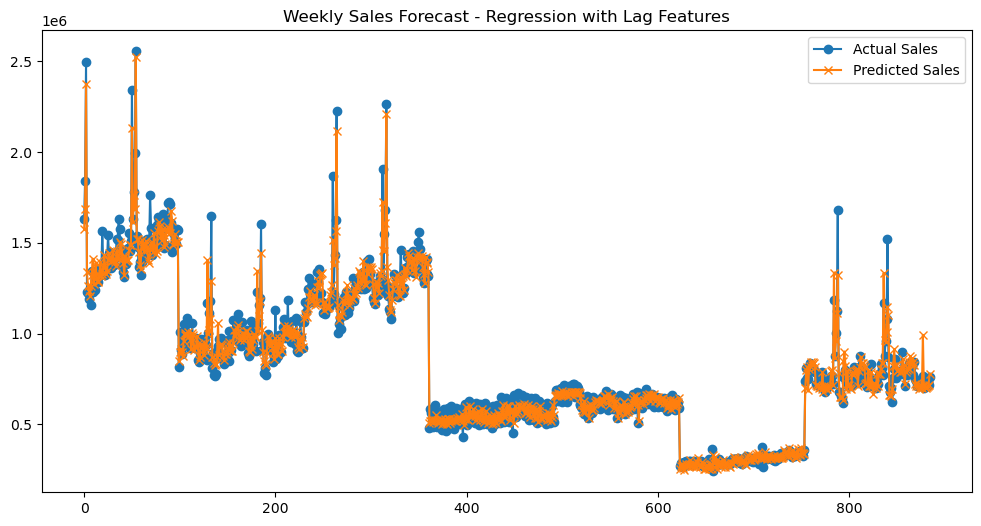

In [62]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Sales", marker="o")
plt.plot(pred_quart_sales, label="Predicted Sales", marker="x")
plt.legend()
plt.title("Weekly Sales Forecast - Regression with Lag Features")
plt.show()

In [63]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

model_future = RandomForestRegressor(n_estimators=200, random_state=42)
model_future.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [64]:
future_preds = []
history = sales_data.copy()  # use the training history

last_date = sales_data['Date'].max()
future_dates = pd.date_range(last_date + pd.Timedelta(weeks=1), periods=96, freq='W-FRI')

for date in future_dates:
    new_row = {
        'Store': history['Store'].iloc[-1],
        'Holiday_Flag': 0,  # assume no holidays
        'Temperature': history['Temperature'].iloc[-1],
        'Fuel_Price': history['Fuel_Price'].iloc[-1],
        'CPI': history['CPI'].iloc[-1],
        'Unemployment': history['Unemployment'].iloc[-1],
        'Sales_Category': history['Sales_Category'].iloc[-1],  # keep same category
        'Year': date.year,
        'Month': date.month,
        'Day': date.day,
        'Week': date.isocalendar().week,
        'lag_1': history['Weekly_Sales'].iloc[-1],
        'lag_2': history['Weekly_Sales'].iloc[-2],
        'lag_3': history['Weekly_Sales'].iloc[-3],
        'rolling_mean_4': history['Weekly_Sales'].iloc[-4:].mean(),
        'rolling_mean_12': history['Weekly_Sales'].iloc[-12:].mean()
    }

    # Ensure column order matches training
    X_new = pd.DataFrame([new_row])[model_future.feature_names_in_]
    y_new = model_future.predict(X_new)[0]

    # Save prediction
    future_preds.append({'Date': date, 'Predicted_Sales': y_new})

    # Append to history so future lags/rollings update correctly
    history = pd.concat([history, pd.DataFrame([{
        **new_row,
        'Weekly_Sales': y_new
    }])], ignore_index=True)

future_df = pd.DataFrame(future_preds)


In [65]:
plot_df = pd.concat([
    sales_data[['Date', 'Weekly_Sales']].rename(columns={'Weekly_Sales': 'Sales'}),
    future_df.rename(columns={'Predicted_Sales': 'Sales'})
])
plot_df['Type'] = ['Actual'] * len(sales_data) + ['Forecast'] * len(future_df)

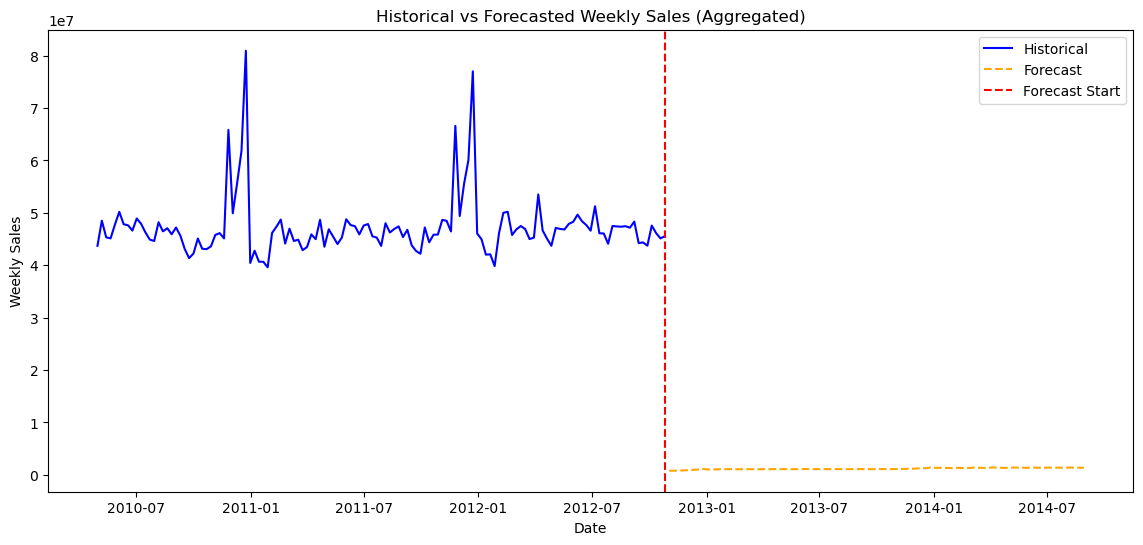

In [66]:
plt.figure(figsize=(14,6))

# Aggregate historical sales across all stores
hist_df = plot_df[plot_df['Type'] == 'Actual']
hist_agg = hist_df.groupby('Date', as_index=False)['Sales'].sum()

# Aggregate forecasted sales
forecast_df = plot_df[plot_df['Type'] == 'Forecast']
forecast_agg = forecast_df.groupby('Date', as_index=False)['Sales'].sum()

# Plot aggregated historical (one line)
plt.plot(hist_agg['Date'], hist_agg['Sales'], label="Historical", color="blue")

# Plot aggregated forecast
plt.plot(forecast_agg['Date'], forecast_agg['Sales'], label="Forecast", color="orange", linestyle="--")

# Mark forecast start
plt.axvline(sales_data['Date'].max(), color='red', linestyle='--', label='Forecast Start')

plt.title("Historical vs Forecasted Weekly Sales (Aggregated)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


#### Seems like we did a really bad job forecasting. Its because these models dont work well when it comes to time. Lets try another model a different forecasting one

In [67]:
!pip install prophet

In [68]:
from prophet import Prophet

In [69]:
hist_agg = sales_data.groupby('Date', as_index=False)['Weekly_Sales'].sum()
df_prophet = hist_agg.rename(columns={'Date':'ds','Weekly_Sales':'y'})

In [70]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

11:29:54 - cmdstanpy - INFO - Chain [1] start processing
11:29:54 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
future = m.make_future_dataframe(periods=96, freq='W')
forecast = m.predict(future)

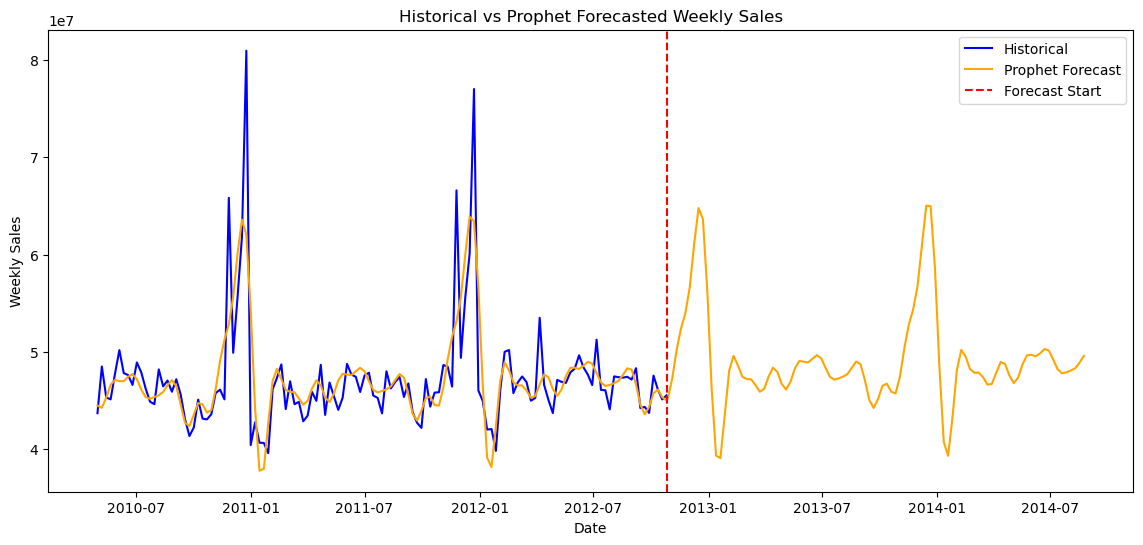

In [72]:
plt.figure(figsize=(14,6))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Historical", color="blue")
plt.plot(forecast['ds'], forecast['yhat'], label="Prophet Forecast", color="orange")
forecast_start = df_prophet['ds'].max()
plt.axvline(forecast_start, color='red', linestyle='--', label="Forecast Start")
plt.title("Historical vs Prophet Forecasted Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

#### Looks like a good forecasting of the future sales